# Classify spam mail using BERT

In [1]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"
!pip install -U "tensorflow==2.15"
!pip install -U "tensorflow_hub==0.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling tensorflow-2.15.1:
      Successfully uninstalled tensorflow-2.15.1


In [3]:
import tensorflow_hub as hub
import tensorflow_text

In [4]:
import tensorflow as tf

In [5]:
print(hub.__version__)


0.15.0


In [6]:
print(tf.__version__)

2.15.0


In [9]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
print(tensorflow_text.__version__ )

2.15.0


 Import BERT model and get embeding vectors for few sample statements


In [11]:
# Load BERT preprocessing and encoder models from TensorFlow Hub
bert_preprocess_model = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_encoder_model = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

bert_preprocess = hub.KerasLayer(bert_preprocess_model)
bert_encoder = hub.KerasLayer(bert_encoder_model)


In [ ]:
!pip install --upgrade  tf_keras

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [13]:
# Define the text input layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
print(text_input)
#text = ["This is a sample sentence."]

# Preprocess the text input
preprocessed_text = bert_preprocess(text_input)

# Encode the preprocessed text
encoded_text = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(encoded_text['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='text'), name='text', description="created by layer 'text'")


In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

# Import the dataset (Dataset is taken from kaggle)

In [15]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Split the dataset

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])

In [18]:
len(X_train)

4179

Model compile

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.fit(X_train, y_train, epochs=5)


Epoch 1/5
131/131 [==============================] - 56s 325ms/step - loss: 0.3883 - accuracy: 0.8406
Epoch 2/5
131/131 [==============================] - 45s 341ms/step - loss: 0.2678 - accuracy: 0.8792
Epoch 3/5
131/131 [==============================] - 43s 331ms/step - loss: 0.2245 - accuracy: 0.9043
Epoch 4/5
131/131 [==============================] - 44s 333ms/step - loss: 0.1945 - accuracy: 0.9225
Epoch 5/5
131/131 [==============================] - 44s 333ms/step - loss: 0.1771 - accuracy: 0.9352


Evaluate

In [21]:
model.evaluate(X_test, y_test)


44/44 [==============================] - 15s 332ms/step - loss: 0.1722 - accuracy: 0.9160


[0.1721869856119156, 0.9160085916519165]

In [24]:
reviews = [
    'Must Watch: Give Height to Your Productivity with IntelliJ IDEA',
    'Win Prizes Worth Rs. Rs. 25000 And Amazon Vouchers In This Simple Coding Contest - Participate Today',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'HBardstown is experimenting with Indian whisky',
    'Tired of egg-shaped EVs? Kia has the antidote.r .'
]
model.predict(reviews)

1/1 [==============================] - 0s 58ms/step


array([[0.03229808],
       [0.24478364],
       [0.26472756],
       [0.0403656 ],
       [0.0050233 ]], dtype=float32)

In [25]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

44/44 [==============================] - 15s 328ms/step


In [26]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 1])

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[1199,    7],
       [ 110,   77]])

Text(50.722222222222214, 0.5, 'Truth')

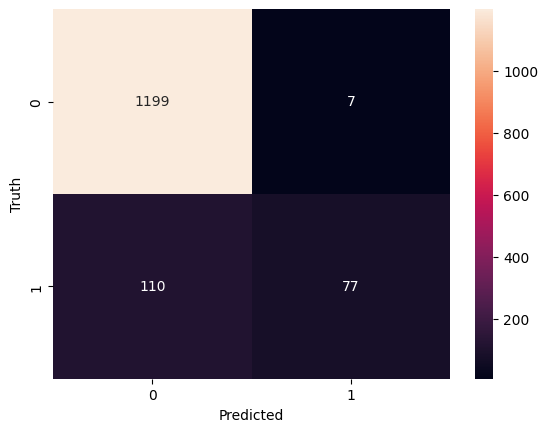

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [29]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1206
           1       0.92      0.41      0.57       187

    accuracy                           0.92      1393
   macro avg       0.92      0.70      0.76      1393
weighted avg       0.92      0.92      0.90      1393

